### Particle near a wall

Simulation of a squirmer near an infinite and plane wall at $z=0$.

In [2]:
%matplotlib inline
from solveWall import Rbm
import numpy as np, matplotlib.pyplot as plt
import pystokes

In [3]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

In [66]:
# particle radius, and fluid viscosity
b, eta = 1.0, 1.

## squirmer
D0  = 1.0      
S0  = -3/50*D0    # beta = 1 (positive beta is a puller (negative V2s)) - not sure which sign!

In [67]:
## initialise 
#initial position
r = np.array([0.,0.,3.])

#initial orientation
p = np.array([1., 0., 0])

## rotate -50deg to x axis around y axis
p = rotation(p, 0., -50 * 2*np.pi/360, 0.)


# initial slip modes
S = np.zeros(9)
D = np.zeros(3)

## S in order: xx, xy, xz, yx, yy, yz, zx, zy, zz
S[0] = S0*(3*p[0]*p[0] - 1.)
S[1] = S0*(3*p[0]*p[1])
S[2] = S0*(3*p[0]*p[2])
S[3] = S0*(3*p[1]*p[0])
S[4] = S0*(3*p[1]*p[1] - 1.)
S[5] = S0*(3*p[1]*p[2]) 
S[6] = S0*(3*p[2]*p[1])
S[7] = S0*(3*p[2]*p[1])
S[8] = S0*(3*p[2]*p[2] - 1.)

D[0] = D0*p[0]
D[1] = D0*p[1]
D[2] = D0*p[2]

In [94]:
def rhs(rp): ##change this to give polarisation directly
    """
    Function that gives rhs for equations dr/dt=v and dp/dt= o x p
    """
    
    #position and angle theta (relative to initial angle)
    r = rp[0:3]; p = rp[3:6]
    
    ## make sure orientation remains unit length
    #norm_p = np.dot(p,p)
    #p = p/np.sqrt(norm_p)
    
    
    F, T, v, o = np.zeros(3), np.zeros(3), np.zeros(3), np.zeros(3)
             
    F[0] = 0.0
    F[1] = 0.0 
    F[2] = -1e-3  ## weak gravity 

    T[0] = 0.0
    T[1] = 0.0
    T[2] = 0.0

    v[0] = 0.0
    v[1] = 0.0
    v[2] = 0.0

    o[0] = 0.0
    o[1] = 0.0
    o[2] = 0.0


    S[0] = S0*(3*p[0]*p[0] - 1.)
    S[1] = S0*(3*p[0]*p[1])
    S[2] = S0*(3*p[0]*p[2])
    S[3] = S0*(3*p[1]*p[0])
    S[4] = S0*(3*p[1]*p[1] - 1.)
    S[5] = S0*(3*p[1]*p[2]) 
    S[6] = S0*(3*p[2]*p[1])
    S[7] = S0*(3*p[2]*p[1])
    S[8] = S0*(3*p[2]*p[2] - 1.)

    D[0] = D0*p[0]
    D[1] = D0*p[1]
    D[2] = D0*p[2]

    
    #update repulsive force at position r
    #forces.lennardJones(F, r, lje=5.0, ljr=2.1*b)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    particle.krylovSolve(v, o, r, F, T, S, D)
    
    dpdt = np.zeros(3)
    
    dpdt[0] = o[1]*p[2] - o[2]*p[1]    
    dpdt[1] = o[2]*p[0] - o[0]*p[2]  
    dpdt[2] = o[0]*p[1] - o[1]*p[0]
        

    
    #return velocity and angular velocity cross orientation as right-hand side
    return np.concatenate( (v,dpdt) )

In [95]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=time_points, **kwargs)
        
    return X

In [96]:
%%time
#initiallize system and forces
particle = Rbm(b, eta)
forces  = pystokes.forceFields.Forces(particles=1)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 200
Npts = 200

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1,  ##have subtracted active velocity V^A = 0.2*D
             method='RK45')
X.message

CPU times: user 11.2 s, sys: 12.1 ms, total: 11.2 s
Wall time: 11.2 s


'Required step size is less than spacing between numbers.'

In [97]:
pos = X.y.T[:,0:3]
times = X.t

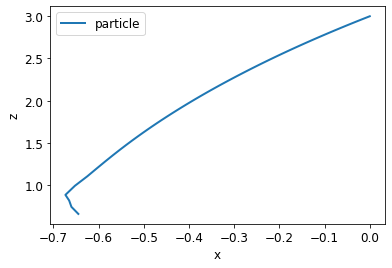

In [98]:
plt.rcParams.update({'font.size': 12})
plt.plot(pos[:,0], pos[:,2], label='particle', lw=2)
plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.show()

In [99]:
orientation = X.y.T[:,3:]

In [100]:
orientation

array([[0.64278761, 0.        , 0.76604444],
       [0.64218236, 0.        , 0.7665519 ],
       [0.64157207, 0.        , 0.76706276],
       [0.64095663, 0.        , 0.7675771 ],
       [0.64033595, 0.        , 0.76809496],
       [0.63970993, 0.        , 0.76861642],
       [0.63907848, 0.        , 0.76914153],
       [0.63844148, 0.        , 0.76967037],
       [0.63779883, 0.        , 0.770203  ],
       [0.63715042, 0.        , 0.77073948],
       [0.63649613, 0.        , 0.7712799 ],
       [0.63583574, 0.        , 0.77182438],
       [0.63516881, 0.        , 0.77237318],
       [0.63449528, 0.        , 0.77292634],
       [0.63381514, 0.        , 0.77348388],
       [0.63312833, 0.        , 0.77404583],
       [0.63243479, 0.        , 0.77461224],
       [0.63173445, 0.        , 0.77518315],
       [0.63102723, 0.        , 0.77575863],
       [0.63031303, 0.        , 0.77633873],
       [0.62959174, 0.        , 0.77692353],
       [0.62886323, 0.        , 0.77751311],
       [0.

In [104]:
np.linalg.norm(p)

1.0